In [1]:
import numpy as np
import cv2
from skimage.segmentation import clear_border
import matplotlib.pyplot as plt

from bubblekicker.bubblekicker import (BubbleKicker, batchbubblekicker, bubble_properties_calculate, 
                                       _bubble_properties_filter, bubble_properties_plot)

from bubblekicker.pipelines import CannyPipeline, AdaptiveThresholdPipeline
import matplotlib
from matplotlib import pyplot as plt
import os
import seaborn as sns
import sys
%matplotlib inline

<b>Questo notebook vuole ottimizzare l'analisi delle immagini di granuli aerobici</b> 

<b>usa la variabile path, in questo modo, quando lo usi te, basta che tu tolga il commento $#$ dalla tua e tu lo metta alla mia riga<\b>

come vedi sotto, facendo semplicemente la somma di queste stringhe riesci a costruire la destinazione dell'immagine

# Carica l'immagine

In [194]:
#path = r'C:\Users\Serena\Desktop' # PC Serena
path = r'C:\Users\Giacomo\Documents\gitRepos\Serena\shared_nbks' # PC Giacomo
path + '\\' + 'classe 5.JPG'

'C:\\Users\\Giacomo\\Documents\\gitRepos\\Serena\\shared_nbks\\classe 5.JPG'

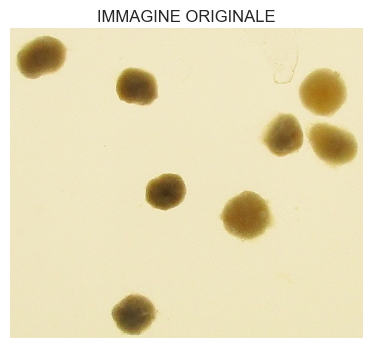

In [195]:
img = cv2.imread(path + '\\' + 'classe 5.JPG')

# divide l'immagine nei layer base
img_B,img_G,img_R = cv2.split(img)

#crea una nuova variabile con i layer reimpostati
img2 = cv2.merge((img_R,img_G,img_B))

# salva l'immagine originale ricomposta
plt.imshow(img2), plt.xticks([]), plt.yticks([]), plt.grid('on'), plt.title('IMMAGINE ORIGINALE'); 
plt.savefig(path + '\\'+ 'OriginalRGB.jpg',dpi=500)

<b>sotto si vede che il canale BLU da' il miglior contrasto<b>

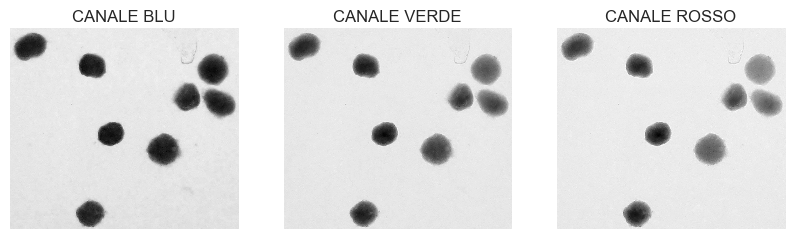

In [7]:
#mostra e salva i diversi canali
plt.figure(figsize=(10, 10))
plt.subplot(3,3,1),plt.imshow(img_B, cmap='gray'), plt.title('CANALE BLU'), plt.xticks([]), plt.yticks([]); 
plt.subplot(3,3,2), plt.imshow(img_G, cmap='gray'), plt.title('CANALE VERDE'), plt.xticks([]), plt.yticks([]); 
plt.subplot(3,3,3), plt.imshow(img_R, cmap='gray'), plt.title('CANALE ROSSO'), plt.xticks([]), plt.yticks([]); 
plt.savefig(path + '\\' + 'channels.jpg',dpi=500)

Dopo aver scelto il canale che sembra migliore si procede con la binarizzazione dell'immagine. La scelta del canle migliore e' importante per facilitare proprio il prossimo step.

# Elaborazione immagine

Aggiustando un pochino i parametri sembra di riuscire meglio a catturare bene i granuli (valori originali 91 e 15)
Inoltre si determinano meglio i bordi e si riesce a perdere roba troppo piccola (bisogna pero' provare se funziona anche con  granuli piu' piccoli)

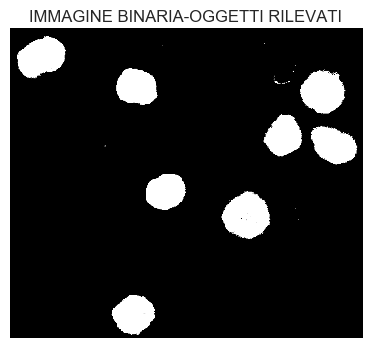

In [196]:
# provvede ad un riconoscimento adattivo dei contorni
binImg = cv2.adaptiveThreshold(img_B, 1, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 201, 25)
plt.imshow(binImg), plt.title('IMMAGINE BINARIA-OGGETTI RILEVATI'), plt.xticks([]), plt.yticks([]), plt.grid('on');  
plt.savefig(path + '\\' + 'oggetti_rilevati.jpg',dpi=500)

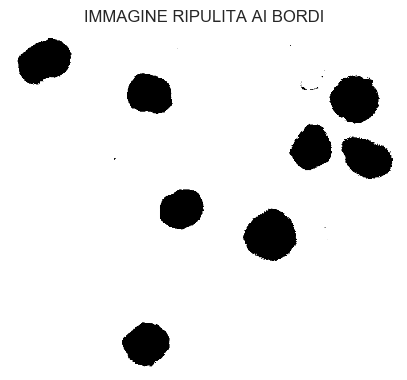

In [197]:
dst_inv = cv2.bitwise_not(binImg) 
img_clb = clear_border(dst_inv, buffer_size=5, bgval=1)
plt.figure(figsize=(5,5))
plt.imshow(img_clb), plt.title('IMMAGINE RIPULITA AI BORDI'), plt.grid('on'), plt.xticks([]), plt.yticks([]);
plt.savefig(path + '\\' + 'IMMAGINE RIPULITA AI BORDI.jpg', dpi=500)

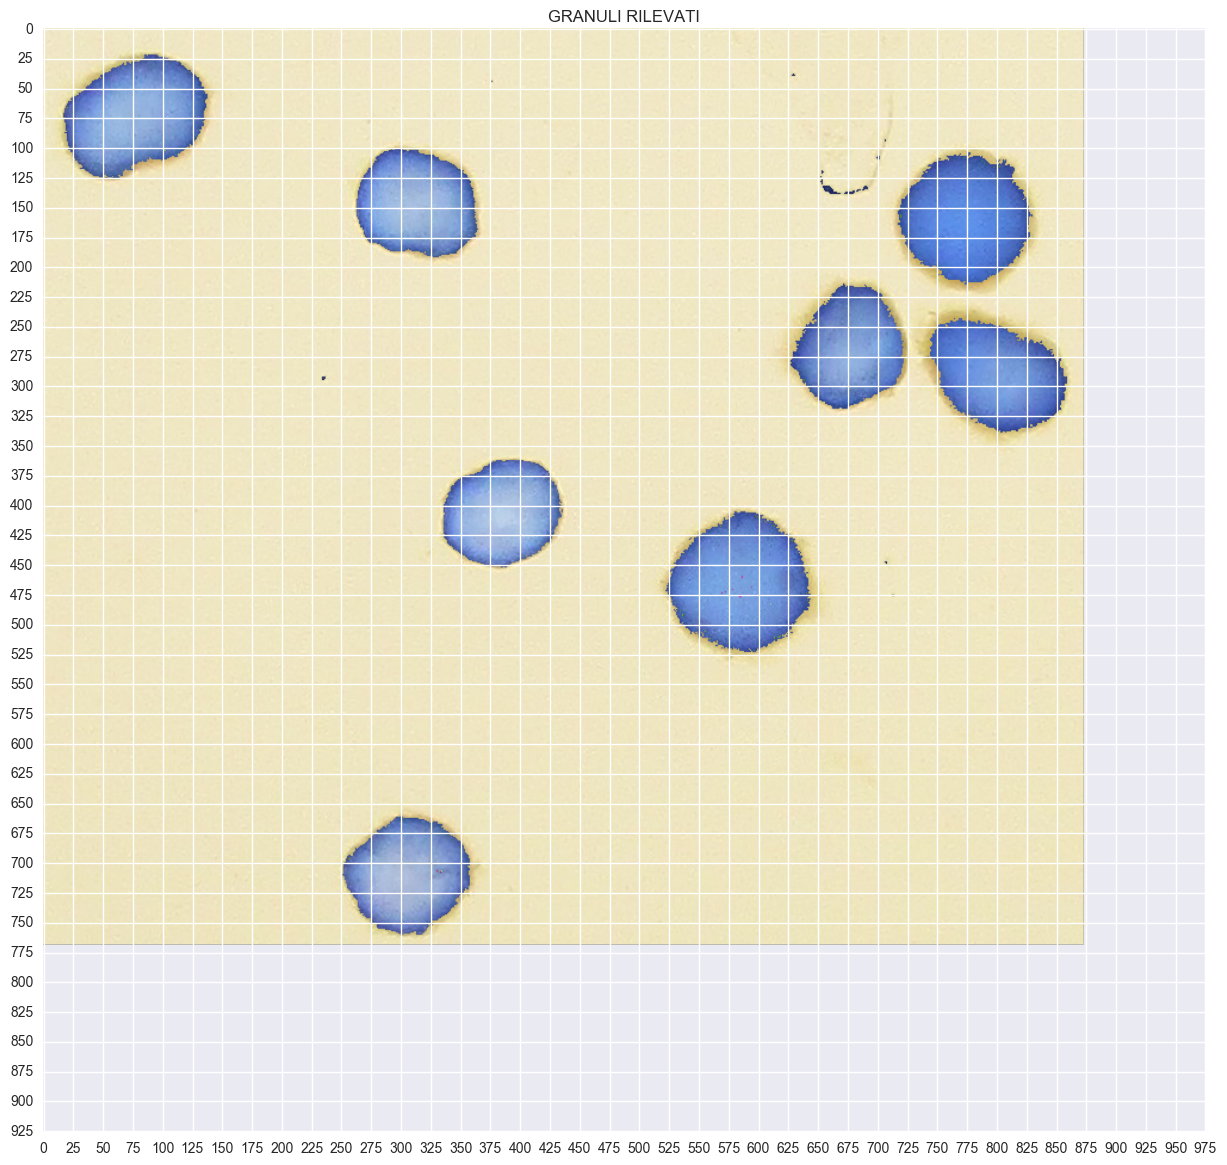

In [198]:
img_outl = cv2.merge((img_R * img_clb, img_G * img_clb, img_B * img_clb))
plt.figure(figsize=(15, 15));
plt.imshow(img_G * img_clb), plt.title('GRANULI RILEVATI')
plt.imshow(img_outl), plt.title('GRANULI RILEVATI')
plt.xticks([25*k for k in range(0,40)])
plt.yticks([25*k for k in range(0,38)])
plt.savefig(path + '\\' + 'GRANULI_RILEVATI.jpg',dpi=500)


A questo punto si passa subito a calcolare le proprieta' dei granuli. 
<p><b> DOMANDA: hai deciso di non fare lo step di erodere e dilatare i bordi di proposito? <b\>

In [199]:
# calcola le proprieta' dei blob nell'immagine
marker_image, props = bubble_properties_calculate(img_clb,rules={'convexity': {'min':1.9 }, 
                                                                 'circularity_reciprocal': {'max': 5, 'min': 0.2}});

{'max': 5, 'min': 0.2}
{'min': 1.9}


questa e' l'immagine che deriva dal passaggio di calcolo delle proprieta'
##### si vede che la roba piccola e' stata eliminata, sono rimasti solo i granuloni e sembrano tutti sopra i 2mm

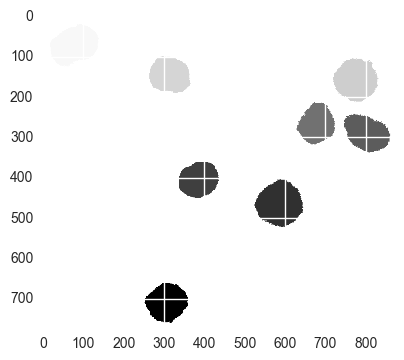

In [200]:
plt.imshow(marker_image, cmap='gray_r');

In [201]:
# aggiunge colonna con misura effettiva dei granuli
props['equivalent_diameter_mm'] = props['equivalent_diameter']/49

In [202]:
# definisce classi
def classe(equivalent_diameter_mm):
    if equivalent_diameter_mm >= 1+1:
        return 5 
    elif 0.8+1 <= equivalent_diameter_mm < 1+1:
        return 4
    elif 0.5+1 <= equivalent_diameter_mm < 0.8+1:
        return 3
    elif 0.2+1 <= equivalent_diameter_mm < 0.5+1:
        return 2
    elif equivalent_diameter_mm < 0.2+1:
        return 1

In [203]:
# aggiunge una colonnna 'classe' alle proprieta'
props['classe']=props["equivalent_diameter_mm"].apply(classe)
props.head()

,area,centroid,convex_area,equivalent_diameter,perimeter,convexity,circularity_reciprocal,equivalent_diameter_mm,classe
label,,,,,,,,,
1,8825,"(74.098470255, 76.7716713881)",9301,106.001599,418.853860,21.069401,1.581978,2.163298,5
6,7238,"(147.965874551, 312.815004145)",7488,95.998478,346.391919,20.895407,1.319189,1.959153,4
7,8915,"(159.807739764, 773.575659002)",9463,106.540746,446.510714,19.965926,1.779642,2.174301,5
20,6903,"(269.140084021, 676.41692018)",7211,93.750587,382.019336,18.069766,1.682376,1.913277,4
23,7755,"(291.374725983, 800.181044487)",8229,99.367865,445.753355,17.397513,2.038908,2.027916,5


In [204]:
# conta per ogni classe quanti granuli ci sono
props[['equivalent_diameter_mm', 'classe']].groupby(['classe']).agg(['count'])

,equivalent_diameter_mm
,count
classe,
4,3
5,5


<b> Se guardi l'esempio in bubblekicker_img_processing.ipynb noti (nella sezione 3) che usando l'immagine 'classe 5.JPG' si ottiene 4 granulli per la classe 4 e altri 4 per la classe 5. Questa differenza con questo caso e' dovuta al fatto che dall'altra parte ho usato anche la funzione dilata ed erodi. probabilmente c'era un granulo un pochino al limite tra le due classi e qui' finisce nella 5

In [211]:
# crea una variabile 'classi' con le classi
classi = props["equivalent_diameter_mm"].apply(classe) # queste celle sotto non dovrebbero servirti grazie a questa

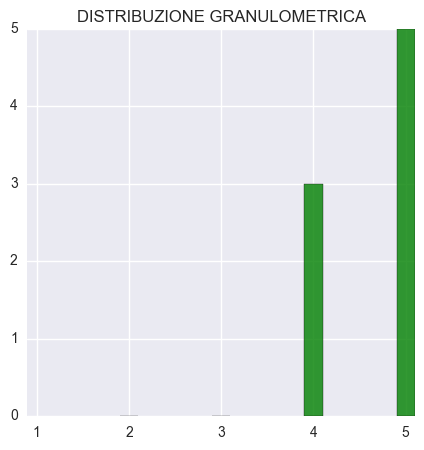

In [212]:
fig = plt.figure(figsize=(5,5));
plt.xticks([k for k in range(0,7)]);
classi.hist(bins=np.arange(1,7)-0.5, rwidth=0.2, color='green', align='mid' , alpha=0.8); #rwidth =spessore barra #non riesco a mettere il numero al centro della barra
plt.grid('on'),plt.title('DISTRIBUZIONE GRANULOMETRICA')
plt.savefig(path + '\\' + 'distribuzione_granulometrica.jpg',dpi=500)

In [207]:
props.head()

,area,centroid,convex_area,equivalent_diameter,perimeter,convexity,circularity_reciprocal,equivalent_diameter_mm,classe
label,,,,,,,,,
1,8825,"(74.098470255, 76.7716713881)",9301,106.001599,418.853860,21.069401,1.581978,2.163298,5
6,7238,"(147.965874551, 312.815004145)",7488,95.998478,346.391919,20.895407,1.319189,1.959153,4
7,8915,"(159.807739764, 773.575659002)",9463,106.540746,446.510714,19.965926,1.779642,2.174301,5
20,6903,"(269.140084021, 676.41692018)",7211,93.750587,382.019336,18.069766,1.682376,1.913277,4
23,7755,"(291.374725983, 800.181044487)",8229,99.367865,445.753355,17.397513,2.038908,2.027916,5


Plotta il centroid

In [208]:
# con questo archivi la posizione x e y e la classe di ogni centroide in tre variabili (x,y e cls)
x = []; y = []; cls = []
for i in props['centroid'].reset_index().index:
    x = np.append(x, props['centroid'].values[i][1])
    y = np.append(y, props['centroid'].values[i][0])
    cls = np.append(cls, props['classe'].values[i])

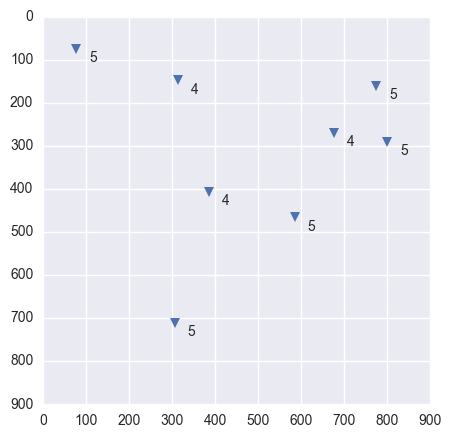

In [209]:
# plotta in automatico la posizione del centroide e ci mette il valore 
fig, ax1 = plt.subplots(figsize=(5,5)) 
ax1.plot(x,y, 'v')
ax1.set_xlim(0,900) # allarga i limiti della figura per far vedere bene anche i punti sul bordo
ax1.set_ylim(0,900) 
ax1.invert_yaxis()  # inverte l'asse y per metterlo come viene messo per visualizzare la figura
for i in np.arange(len(x)):
    ax1.annotate(str(int(cls[i])), xy=(x[i], y[i]), xytext=(x[i]+30, y[i]+30))
                #, arrowprops=dict(facecolor='black', shrink=0.05),) # se ci vuoi mettere anche una freccia togli questo commento

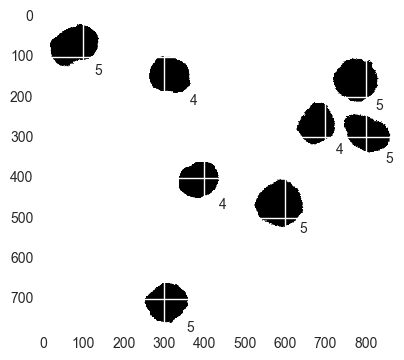

In [210]:
fig, ax1 = plt.subplots()
# il maggiore di zero serve per fare tutti i pippoli neri, se lo levi diventa scala di grigi
ax1.imshow(marker_image>0, cmap='binary', interpolation='bilinear'); 
for i in np.arange(len(x)):
    ax1.annotate(str(int(cls[i])), xy=(x[i], y[i]), xytext=(x[i]+50, y[i]+70)); # possibile futuro miglioramento sara' visualizzare 

In [134]:
#fig = plt.figure(figsize=(10,10))
#sns.pairplot(props)#prendi solo l'immagine che ti interessa...l'ultima
#ax = plt.subplot(111) # crei un'area di plotting
#ax.set_xticks(range(10)) # l'asse x va da 0 a 10
#ax.set_yticks(range(10)) #l'asse y va da 0 a 10
#rect=[49.7609561753, 1916.57768924]
#plt.plot([1,2,3]);
#plt.axis([-1.1, 1.1, -1.1, 1.1]) ;
# plt.xticks([0.25*k for k in range(-4,5)]) ;
#plt.yticks([-0.9, -0.4, 0.0, 0.3, 0.6, 0.85],['A','B','C','D','E','F']
#plt.plot([1,2,3]);
#plt.axis([-1.1, 1.1, -1.1, 1.1]) ;
# plt.xticks([0.25*k for k in range(-4,5)]) ;
#plt.yticks([-0.9, -0.4, 0.0, 0.3, 0.6, 0.85],['A','B','C','D','E','F']);
#plt.title('The cubic function in [-1,1]')
#plt.xlabel('my x-axis label')
#plt.ylabel('my y-axis label')
#plt.grid()

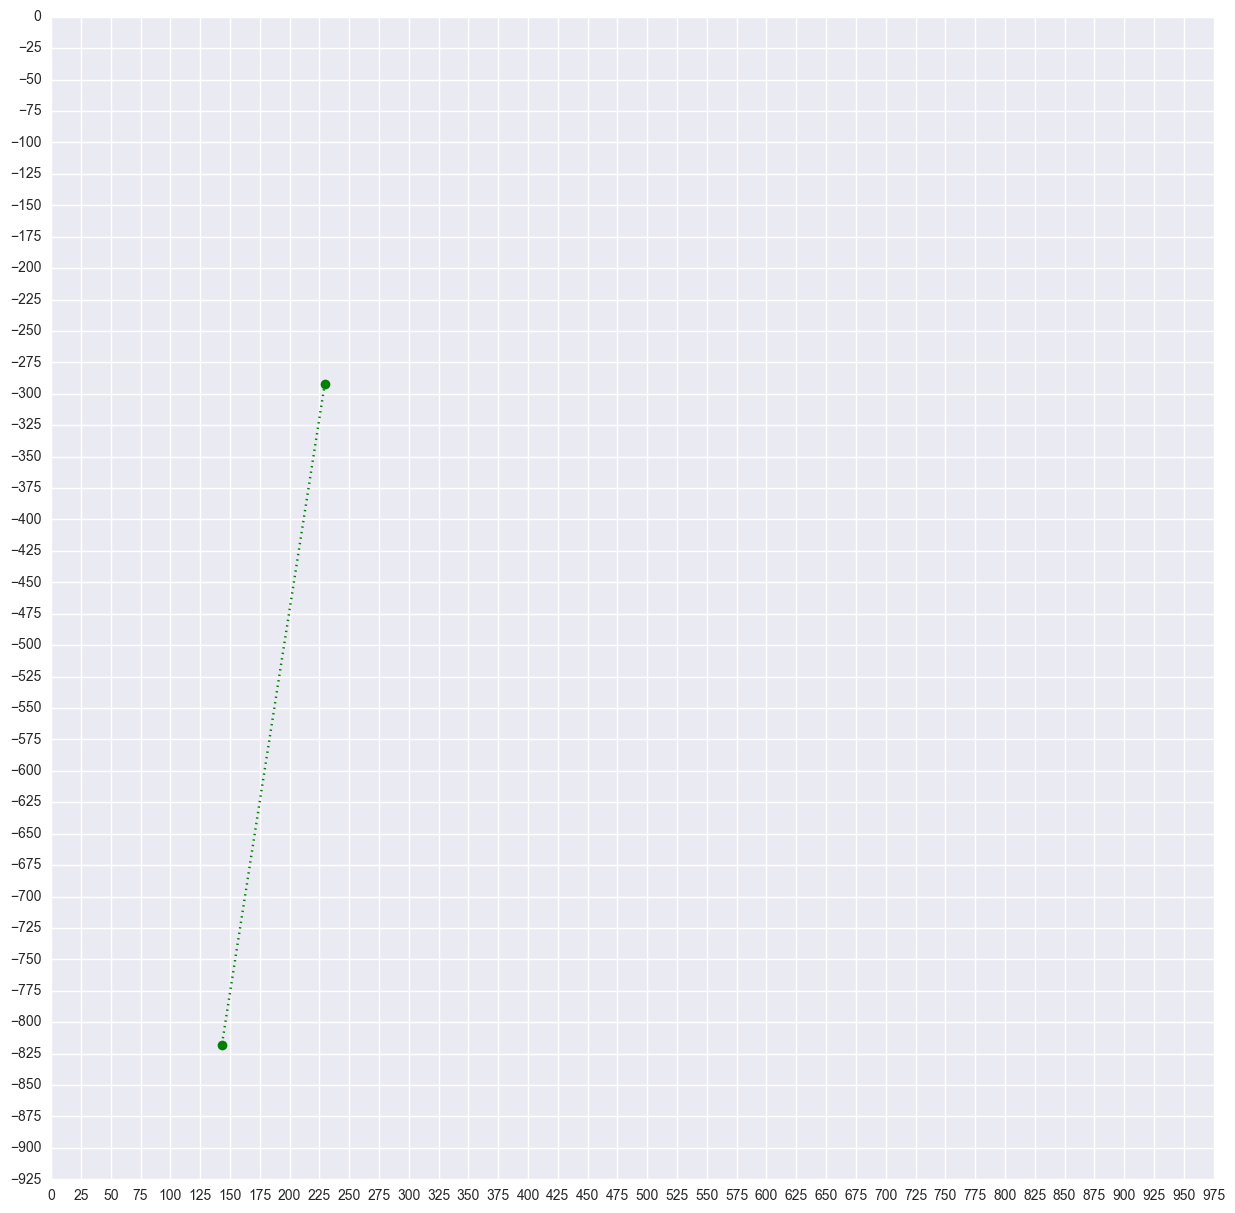

In [135]:
y=-291.942813765,-818.276732939
x=229.537449393,143.197474476
plt.figure(figsize=(15,15)) 
plt.plot(x,y,'g:o'),plt.yticks([25*k for k in range(-37,1)]),plt.xticks([25*k for k in range(0,40)]);#devi trovare il modo di sovrapporle